In [52]:
import os, json, warnings, sys
warnings.filterwarnings("ignore")
sys.path.append('../dashboard/server/')
import numpy as np
import pandas as pd
import torch as ch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import seaborn as sns
import itertools
from api import DataReader
import json

%matplotlib inline
sns.set_style('darkgrid')

In [2]:
LOG_DIR = '/data/theory/robustopt/shibani/synthfar/Results/demo_logs/'

In [3]:
reader = DataReader(os.path.join(LOG_DIR, 'details.log'))
reader.update_data()

  6%|▌         | 134/2186 [00:00<00:01, 1336.49it/s]

### 0 2187 2186


100%|██████████| 2186/2186 [00:01<00:00, 2002.79it/s]


In [4]:
answer = json.loads(reader.answer)

parameters = answer['parameters'] + ['id', 'model', 'environment', 'is_correct']
results = pd.DataFrame(answer['data'], columns=parameters)
results['is_correct'] = results['is_correct'].values.astype('int32')

In [5]:
results

,BackgroundControl.H,BackgroundControl.S,BackgroundControl.V,CameraControl.aperture,CameraControl.focal_length,CameraControl.view_point_x,CameraControl.view_point_y,CameraControl.view_point_z,CameraControl.zoom_factor,ObjLocInFrameControl.x_shift,ObjLocInFrameControl.y_shift,ObjScaleControl.factor,PoseControl.rotation_X,PoseControl.rotation_Y,PoseControl.rotation_Z,id,model,environment,is_correct
0,0.0,0.4,0.4,8,50,1,1,1,1,-0.3,-0.3,1.0,-3.141593,-3.141593,-3.141593,aa31f683-44f2-4c9e-b104-c6559113db61,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,1
1,0.0,0.4,0.4,8,50,1,1,1,1,-0.3,0.0,1.0,-3.141593,-3.141593,-3.141593,0741f7fd-44ea-451f-95e9-a64aac3b5972,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,1
2,0.0,0.4,0.4,8,50,1,1,1,1,-0.3,0.3,1.0,-3.141593,-3.141593,-3.141593,6daa2cb2-5f07-47cc-866a-f5d343286a96,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,1
3,0.0,0.4,0.4,8,50,1,1,1,1,0.0,-0.3,1.0,-3.141593,-3.141593,-3.141593,79fa89ba-c715-4166-980f-e333c3de57c3,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,1
4,0.0,0.4,0.4,8,50,1,1,1,1,0.0,0.0,1.0,-3.141593,-3.141593,-3.141593,cacfd27f-ec34-40b5-9653-f27487e1efdf,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2181,1.0,0.4,0.4,8,50,1,1,1,1,0.0,-0.3,1.5,3.141593,3.141593,3.141593,22701d0a-643c-4dcf-8d65-3c28780ea12d,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,0
2182,1.0,0.4,0.4,8,50,1,1,1,1,0.0,0.0,1.5,3.141593,3.141593,3.141593,21af1b3e-4891-4946-9c37-58dd0d688979,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,0
2183,1.0,0.4,0.4,8,50,1,1,1,1,0.0,0.3,1.5,3.141593,3.141593,3.141593,67aa143f-79cc-48d5-ac71-16673d5d37fb,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,0
2184,1.0,0.4,0.4,8,50,1,1,1,1,0.3,-0.3,1.5,3.141593,3.141593,3.141593,d40ce374-b2f5-494b-8a9e-6b86fd4e68e5,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,1


In [121]:
def stratify(controls_df, group_keys=None, fixed_keys=None):
    
    if group_keys is None and fixed_keys is None: return controls_df
    
    if fixed_keys is not None:
        crit = []
        for k, v in fixed_keys.items():
            crit.append(controls_df[k] == v)
        crit = np.logical_and.reduce(crit)
        bg = controls_df[crit]
    else:
        bg = controls_df
    
    if group_keys:
        bg = bg.groupby(list(group_keys)).agg({'is_correct': 'mean'}).reset_index()
        if len(group_keys) > 1: bg = bg.pivot(*(group_keys + ['is_correct']))
    return bg

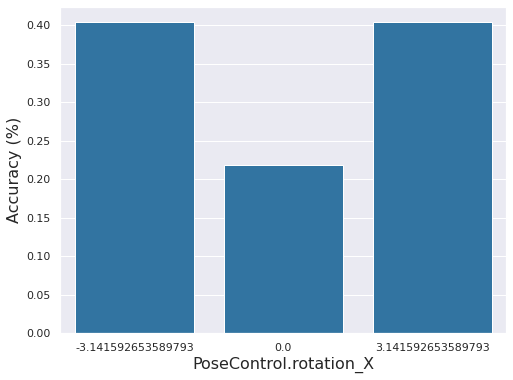

In [134]:
var = 'PoseControl.rotation_X'
fixed = {'BackgroundControl.H': 0.0} # Can be None

df = stratify(results, group_keys=[var], fixed_keys=fixed)


fig = plt.subplots(figsize=(8, 6))
sns.barplot(x=var,  y='is_correct', data=df, color='tab:blue')
plt.ylabel('Accuracy (%)', fontsize=16)
plt.xlabel(var, fontsize=16)

plt.show()

In [178]:
def surface_plot(df, var_name):
    grid = [[], [], []]
    for k in df.keys():
        grid_int = []
        for ki in df[k].keys():
            grid_int.extend([k, ki, df[k][ki]])
        grid[0].append(grid_int[0::3])
        grid[1].append(grid_int[1::3])
        grid[2].append(grid_int[2::3])

    grid = np.asarray(grid)
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot_surface(grid[0], grid[1], grid[2], cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_xlabel(var_name[0], fontsize=16)
    ax.set_ylabel(var_name[1], fontsize=16)
    ax.set_zlabel("Accuracy (%)", fontsize=16)

    ax.view_init(30, -40)
    plt.tight_layout()

    plt.show()

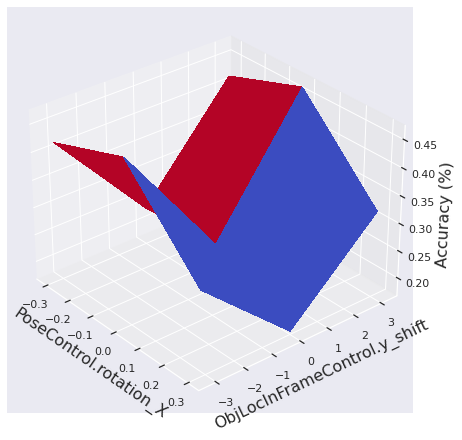

In [179]:
var = ['PoseControl.rotation_X', 'ObjLocInFrameControl.y_shift']
fixed = {'BackgroundControl.H': 0.0} # Can be None

df = stratify(results, group_keys=var, fixed_keys=fixed)

surface_plot(df, var)

In [187]:
def heatmap(controls_df, group_key_list, writer=None):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    sns.set(font_scale=1)
    cbar_ax = fig.add_axes([1.01, .3, .03, .4])


    for gi, group_keys in enumerate(group_key_list):

        bg = stratify(results, group_keys=list(group_keys))
        res = sns.heatmap(bg, vmin=0, vmax=1, cmap='RdBu', 
                          ax=ax[gi], cbar=gi==0,
                          cbar_ax=None if gi else cbar_ax)
        res.set_xlabel(res.get_xlabel(), fontsize=18)
        res.set_ylabel(res.get_ylabel(), fontsize=18)

    plt.subplots_adjust(wspace=0.3)
    plt.tight_layout()
    
    if writer:
        writer.add_figure('background', fig)
    else:
        plt.show()

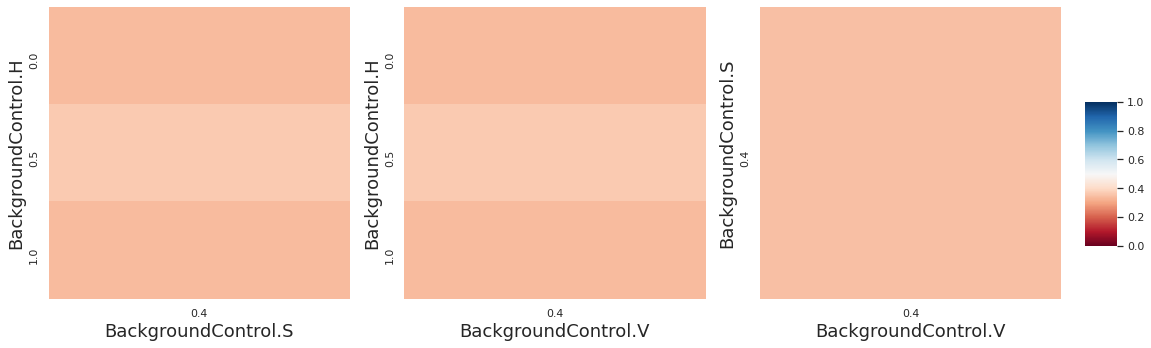

In [188]:
var = ['BackgroundControl.H', 'BackgroundControl.S', 'BackgroundControl.V']

heatmap(results, group_key_list=itertools.combinations(var, 2))

In [189]:
results

,BackgroundControl.H,BackgroundControl.S,BackgroundControl.V,CameraControl.aperture,CameraControl.focal_length,CameraControl.view_point_x,CameraControl.view_point_y,CameraControl.view_point_z,CameraControl.zoom_factor,ObjLocInFrameControl.x_shift,ObjLocInFrameControl.y_shift,ObjScaleControl.factor,PoseControl.rotation_X,PoseControl.rotation_Y,PoseControl.rotation_Z,id,model,environment,is_correct
0,0.0,0.4,0.4,8,50,1,1,1,1,-0.3,-0.3,1.0,-3.141593,-3.141593,-3.141593,aa31f683-44f2-4c9e-b104-c6559113db61,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,1
1,0.0,0.4,0.4,8,50,1,1,1,1,-0.3,0.0,1.0,-3.141593,-3.141593,-3.141593,0741f7fd-44ea-451f-95e9-a64aac3b5972,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,1
2,0.0,0.4,0.4,8,50,1,1,1,1,-0.3,0.3,1.0,-3.141593,-3.141593,-3.141593,6daa2cb2-5f07-47cc-866a-f5d343286a96,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,1
3,0.0,0.4,0.4,8,50,1,1,1,1,0.0,-0.3,1.0,-3.141593,-3.141593,-3.141593,79fa89ba-c715-4166-980f-e333c3de57c3,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,1
4,0.0,0.4,0.4,8,50,1,1,1,1,0.0,0.0,1.0,-3.141593,-3.141593,-3.141593,cacfd27f-ec34-40b5-9653-f27487e1efdf,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2181,1.0,0.4,0.4,8,50,1,1,1,1,0.0,-0.3,1.5,3.141593,3.141593,3.141593,22701d0a-643c-4dcf-8d65-3c28780ea12d,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,0
2182,1.0,0.4,0.4,8,50,1,1,1,1,0.0,0.0,1.5,3.141593,3.141593,3.141593,21af1b3e-4891-4946-9c37-58dd0d688979,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,0
2183,1.0,0.4,0.4,8,50,1,1,1,1,0.0,0.3,1.5,3.141593,3.141593,3.141593,67aa143f-79cc-48d5-ac71-16673d5d37fb,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,0
2184,1.0,0.4,0.4,8,50,1,1,1,1,0.3,-0.3,1.5,3.141593,3.141593,3.141593,d40ce374-b2f5-494b-8a9e-6b86fd4e68e5,ba705749a39d4f5382b265c7b157e962.blend,white_background.blend,1
